# "Record" "linear song features"

I.e. create reduced design matrices for song->behavior prediction by projecting song history onto pre-determined basis functions.

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal, stats
from sklearn import linear_model
import sys
import warnings

from disp import set_font_size, set_plot
from my_stats import nanpearsonr

warnings.filterwarnings("ignore")

cc = np.concatenate

FPS = 30.03
DT = 1/FPS

SAVE_DIR_RECT = 'data/simple/mlv/lin_filter/rect_lin'
PFX_RECT = 'rect_lin'

SAVE_DIR_RC = 'data/simple/mlv/lin_filter/rc_lin'
PFX_RC = 'rc_lin'

## Coen et al data

In [2]:
df_behav = pd.read_csv('data/simple/c_song_f_behav.csv')
df_behav

,ID,FRAME,T,Q,S,P,F,FFV,FFA,FLS,FRS,FMFV,FMLS
0,0,0,0.000000,1,0,0,0,0.231,0.0000,0.159,0.077,-0.058526,0.274257
1,0,1,0.033300,1,0,0,0,0.314,0.0385,0.025,0.044,0.100623,0.298490
2,0,2,0.066600,1,0,0,0,0.308,0.0025,0.029,0.011,0.147629,0.271865
3,0,3,0.099900,1,0,0,0,0.319,0.0020,0.016,0.016,0.091174,0.306112
4,0,4,0.133200,1,0,0,0,0.312,-0.0315,0.030,0.002,0.065871,0.306439
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4978565,275,27100,902.430902,1,0,0,0,0.217,0.0280,0.029,0.058,-0.171418,0.136184
4978566,275,27101,902.464202,1,0,0,0,0.210,-0.1045,0.138,0.322,0.032522,0.249171
4978567,275,27102,902.497502,1,0,0,0,0.008,-0.0910,0.034,0.260,0.033202,0.010844
4978568,275,27103,902.530803,1,0,0,0,0.028,0.0695,0.010,0.090,0.012059,0.027177


In [3]:
# split big df into dfs for individual trials
n_tr = np.max(df_behav.ID) + 1
dfs_tr = [df_behav[df_behav.ID == i] for i in range(n_tr)]
df_behav = None

# Filters

In [4]:
MAX_T = 120  # max look-back window
T_H = np.arange(0, MAX_T, DT)

## Stretched rectangular basis

17 filters


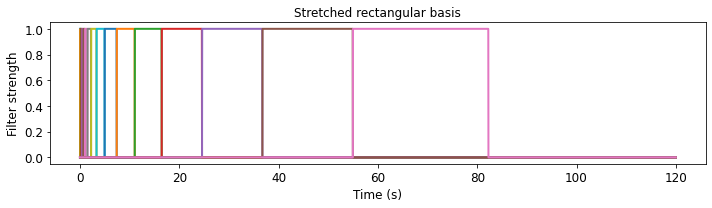

In [5]:
NDT_0 = 1  # width of closest filter
STRETCH = 1.5  # stretch factor relative to distance
hs_rect = []

istart = 0
istop = 0
ndt = NDT_0
while (istart+ndt)*DT < MAX_T:
    
    h_rect = np.zeros(T_H.shape)
    h_rect[istart:istart+ndt] = 1/(ndt*DT)
    hs_rect.append(h_rect.copy())
    
    istart = istart+ndt+1
    ndt = int(round(STRETCH*ndt))
    
hs_rect = np.array(hs_rect)

fig, ax = plt.subplots(1, 1, figsize=(10, 3), tight_layout=True)
for h_rect in hs_rect:
    ax.plot(T_H, h_rect/h_rect.max(), lw=2)
    
set_plot(ax, x_label='Time (s)', y_label='Filter strength', title='Stretched rectangular basis', font_size=12)
print(f'{len(hs_rect)} filters')

## Raised cosine basis

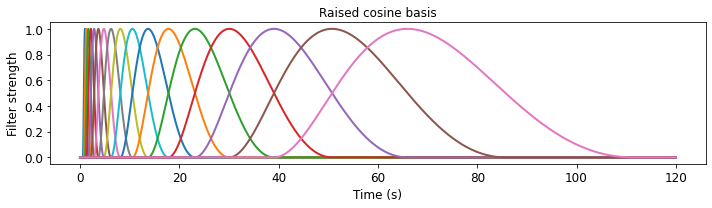

In [6]:
hs_rc = []
a = 6
c = 0
phis = np.arange(len(hs_rect)) * np.pi/2

for ch, phi in enumerate(phis):
    h_rc = .5*np.cos(a*np.log(T_H + c) - phi) + .5
    mt_zero = (a*np.log(T_H + c) < (phi-np.pi)) | (a*np.log(T_H + c) >= (phi+np.pi))
    h_rc[mt_zero] = 0
    hs_rc.append(h_rc)
    
hs_rc = np.array(hs_rc)
    
fig, ax = plt.subplots(1, 1, figsize=(10, 3), tight_layout=True)
for h_rc in hs_rc:
    ax.plot(T_H, h_rc/h_rc.max(), lw=2)
    
set_plot(ax, x_label='Time (s)', y_label='Filter strength', title='Raised cosine basis', font_size=12)

In [7]:
# loop over trials and project song onto basis functions
for ctr, df_tr in enumerate(dfs_tr):
    sys.stdout.write('.')
    
    # song
    i_s = np.array(df_tr['S']).astype(float)
    i_p = np.array(df_tr['P'] | df_tr['F']).astype(float)
    
    # stretched rectangular basis
    df_tr_rect_lin = df_tr.copy()
    
    for ch, h_rect in enumerate(hs_rect):
        df_tr_rect_lin[f'S_{ch}'] = DT*signal.fftconvolve(i_s, h_rect, mode='full')[:len(i_s)]
        df_tr_rect_lin[f'P_{ch}'] = DT*signal.fftconvolve(i_p, h_rect, mode='full')[:len(i_p)]
        
    np.save(os.path.join(SAVE_DIR_RECT, f'{PFX_RECT}_tr_{ctr}.npy'), np.array([{'df': df_tr_rect_lin}]))
    
    # raised cosine basis
    df_tr_rc_lin = df_tr.copy()
    
    for ch, h_rc in enumerate(hs_rc):
        df_tr_rc_lin[f'S_{ch}'] = DT*signal.fftconvolve(i_s, h_rc, mode='full')[:len(i_s)]
        df_tr_rc_lin[f'P_{ch}'] = DT*signal.fftconvolve(i_p, h_rc, mode='full')[:len(i_p)]
        
    np.save(os.path.join(SAVE_DIR_RC, f'{PFX_RC}_tr_{ctr}.npy'), np.array([{'df': df_tr_rc_lin}]))

....................................................................................................................................................................................................................................................................................

## WT Gold behavioral data

In [2]:
df_behav = pd.read_csv('data/simple/w_song_f_behav.csv')
df_behav

,ID,FRAME,T,Q,S,P,F,FFV,FFA,FLS,FRS,FMFV,FMLS
0,0,0,0.000000,1,0,0,0,3.844019,-0.138725,0.841459,3.102308,3.663209,1.244644
1,0,1,0.033300,1,0,0,0,2.645045,0.217158,0.958827,1.644406,2.143699,1.633865
2,0,2,0.066600,1,0,0,0,2.817165,-0.170636,0.799927,0.591572,2.212304,1.895512
3,0,3,0.099900,1,0,0,0,4.238035,0.000825,0.455475,0.842094,3.535255,2.372842
4,0,4,0.133200,1,0,0,0,6.156643,0.280813,0.516347,1.218568,5.392901,2.986841
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2333241,83,11022,367.032967,0,0,0,1,-0.058612,0.000000,0.240739,0.721101,0.063511,0.234946
2333242,83,11023,367.066267,0,0,0,1,0.381769,0.000000,0.156364,0.000000,-0.366270,0.191376
2333243,83,11024,367.099567,0,0,0,1,0.196337,0.000000,0.482724,0.839733,-0.179289,0.481899
2333244,83,11025,367.132867,1,0,0,0,-0.403877,0.000000,0.139698,1.868385,0.410206,0.148874


In [3]:
# split big df into dfs for individual trials
n_tr = np.max(df_behav.ID) + 1
dfs_tr = [df_behav[df_behav.ID == i] for i in range(n_tr)]
df_behav = None

# Filters

In [4]:
MAX_T = 120  # max look-back window
T_H = np.arange(0, MAX_T, DT)

## Stretched rectangular basis

17 filters


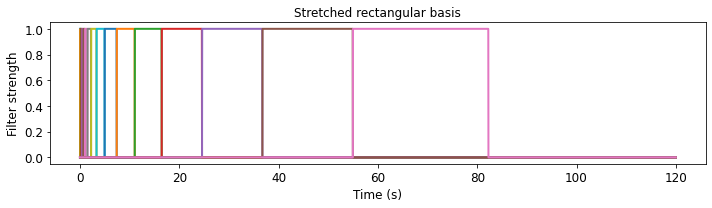

In [5]:
NDT_0 = 1  # width of closest filter
STRETCH = 1.5  # stretch factor relative to distance
hs_rect = []

istart = 0
istop = 0
ndt = NDT_0
while (istart+ndt)*DT < MAX_T:
    
    h_rect = np.zeros(T_H.shape)
    h_rect[istart:istart+ndt] = 1/(ndt*DT)
    hs_rect.append(h_rect.copy())
    
    istart = istart+ndt+1
    ndt = int(round(STRETCH*ndt))
    
hs_rect = np.array(hs_rect)

fig, ax = plt.subplots(1, 1, figsize=(10, 3), tight_layout=True)
for h_rect in hs_rect:
    ax.plot(T_H, h_rect/h_rect.max(), lw=2)
    
set_plot(ax, x_label='Time (s)', y_label='Filter strength', title='Stretched rectangular basis', font_size=12)
print(f'{len(hs_rect)} filters')

## Raised cosine basis

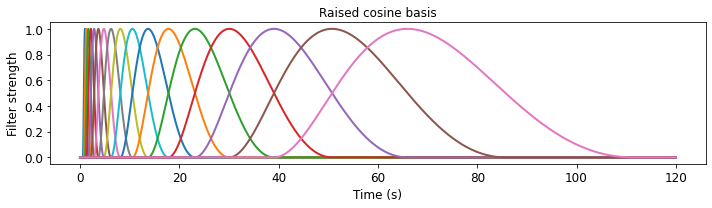

In [6]:
hs_rc = []
a = 6
c = 0
phis = np.arange(len(hs_rect)) * np.pi/2

for ch, phi in enumerate(phis):
    h_rc = .5*np.cos(a*np.log(T_H + c) - phi) + .5
    mt_zero = (a*np.log(T_H + c) < (phi-np.pi)) | (a*np.log(T_H + c) >= (phi+np.pi))
    h_rc[mt_zero] = 0
    hs_rc.append(h_rc)
    
hs_rc = np.array(hs_rc)
    
fig, ax = plt.subplots(1, 1, figsize=(10, 3), tight_layout=True)
for h_rc in hs_rc:
    ax.plot(T_H, h_rc/h_rc.max(), lw=2)
    
set_plot(ax, x_label='Time (s)', y_label='Filter strength', title='Raised cosine basis', font_size=12)

In [7]:
# loop over trials and project song onto basis functions
for ctr, df_tr in enumerate(dfs_tr):
    sys.stdout.write('.')
    
    # song
    i_s = np.array(df_tr['S']).astype(float)
    i_p = np.array(df_tr['P'] | df_tr['F']).astype(float)
    
    # stretched rectangular basis
    df_tr_rect_lin = df_tr.copy()
    
    for ch, h_rect in enumerate(hs_rect):
        df_tr_rect_lin[f'S_{ch}'] = DT*signal.fftconvolve(i_s, h_rect, mode='full')[:len(i_s)]
        df_tr_rect_lin[f'P_{ch}'] = DT*signal.fftconvolve(i_p, h_rect, mode='full')[:len(i_p)]
        
    np.save(os.path.join(SAVE_DIR_RECT, f'{PFX_RECT}_tr_{ctr+276}.npy'), np.array([{'df': df_tr_rect_lin}]))
    
    # raised cosine basis
    df_tr_rc_lin = df_tr.copy()
    
    for ch, h_rc in enumerate(hs_rc):
        df_tr_rc_lin[f'S_{ch}'] = DT*signal.fftconvolve(i_s, h_rc, mode='full')[:len(i_s)]
        df_tr_rc_lin[f'P_{ch}'] = DT*signal.fftconvolve(i_p, h_rc, mode='full')[:len(i_p)]
        
    np.save(os.path.join(SAVE_DIR_RC, f'{PFX_RC}_tr_{ctr+276}.npy'), np.array([{'df': df_tr_rc_lin}]))

....................................................................................